In [1]:
using PauliPropagation
using Random
using Optim
using Plots
Random.seed!(43)
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames
using CSV

# CDR for quantum dynamics
- TFIM Hamiltonian (constants not site-dependent) evolving with TDSE
- discretize the evolution steps and use first-order Trotter decomposition

In [2]:
struct trotter_ansatz_tfim
    target_circuit::Vector{Gate}
    target_circuit_layer::Vector{Gate}
    topology::Vector{Tuple{Int64, Int64}}
    nqubits::Integer
    steps::Integer #layers
    time::Integer
    J::Float64
    h::Float64
    sigma_J::Float64
    sigma_h::Float64
    sigma_J_indices::Vector{Int64}
    sigma_h_indices::Vector{Int64}
    sigma_J_indices_layer::Vector{Int64}
    sigma_h_indices_layer::Vector{Int64}
end

In [3]:
function trotter_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64;topology = nothing)
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    target_circuit = tfitrottercircuit(nqubits,steps,topology=topology) #start with RZZ layer
    target_circuit_layer = tfitrottercircuit(nqubits,1,topology=topology) #start with RZZ layer
    sigma_J = -2*T*J/steps
    sigma_h = 2*T*h/steps 

    sigma_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z,:Z]) 
    sigma_h_indices = getparameterindices(target_circuit, PauliRotation, [:X])
    
    sigma_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z,:Z])
    sigma_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X])
    
    return trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,sigma_J, sigma_h,sigma_J_indices, sigma_h_indices, sigma_J_indices_layer, sigma_h_indices_layer)
end

trotter_setup (generic function with 1 method)

In [4]:
function constrain_params(ansatz; layer = false)

    """
    Function to set all RX gates and all RZZ gates to have the same parameter value respectively.
    """
    
    if layer == false
        nparams = countparameters(ansatz.target_circuit)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices] .= ansatz.sigma_J

    else
        nparams = countparameters(ansatz.target_circuit_layer)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices_layer] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices_layer] .= ansatz.sigma_J

    end
    
    return thetas
end

constrain_params (generic function with 1 method)

In [5]:
function obs_magnetization(ansatz)
    
    """
    Returns the normalised magnetization.
    """

    magnetization = PauliSum(ansatz.nqubits)
    for i in 1:nq
        add!(magnetization,:Z,i)
    end
    magnetization = magnetization/nq
    return magnetization
end

obs_magnetization (generic function with 1 method)

In [6]:
function training_set_generation(ansatz::trotter_ansatz_tfim; num_samples::Int = 10, non_cliffs::Int = 30)

    """
    Generates a training set of thetas for the ansatz. The training set is generated by selecting a number of cliffords and non-cliffords
    and setting the corresponding thetas to multiples of π/4. 
    """
    
    nparams = countparameters(ansatz.target_circuit)
    cliffs = nparams - non_cliffs

    ratio = length(ansatz.sigma_J_indices)/(length(ansatz.sigma_h_indices) + length(ansatz.sigma_J_indices))
    num_h = Int(round((1-ratio)*cliffs))
    num_J = Int(round(ratio*cliffs))
    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    for _ in 1:num_samples
        training_thetas = deepcopy(thetas)
        shuffled_sigma_h_indices =  Random.shuffle!(ansatz.sigma_h_indices)
        shuffled_sigma_J_indices = Random.shuffle!(ansatz.sigma_J_indices)
        selected_indices_h = shuffled_sigma_h_indices[1:num_h]
        selected_indices_J = shuffled_sigma_J_indices[1:num_J];   
        k_h = round(ansatz.sigma_h/(π/4))
        k_J = round(ansatz.sigma_J/(π/4))

        for i in selected_indices_h
            training_thetas[i] = k_h*π/4
        end
        for i in selected_indices_J
            training_thetas[i] = k_J*π/4
        end
        push!(training_thetas_list, training_thetas)
    end
    return training_thetas_list
end

training_set_generation (generic function with 1 method)

In [7]:
function exact_trotter_time_evolution(ansatz; special_theta = nothing, noisy_circuit = false,record = false)

    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    
    layer = record
    if special_theta == nothing
        thetas = constrain_params(ansatz) # layer = layer
    else
        thetas = special_theta
    end
    nparams = countparameters(ansatz.target_circuit)
    obs = obs_magnetization(ansatz)

    if record == false
        if noisy_circuit == false
            noisy_circuit = copy(ansatz.target_circuit)
        end
        psum = propagate!(noisy_circuit,obs,thetas)
    
        return overlapwithzero(psum)

    else 
        expvals_trotter = Float64[]
        if noisy_circuit == false
            noisy_circuit = copy(ansatz.target_circuit_layer)
        end
            push!(expvals_trotter,overlapwithzero(obs_magnetization(ansatz))) #add the initial state to the list
            
        for i in 1:ansatz.steps
            psum = propagate!(noisy_circuit,obs, thetas[Int(nparams/ansatz.steps*(i-1)+1):Int(nparams/ansatz.steps*i)])
            push!(expvals_trotter, overlapwithzero(psum))
        end

        return expvals_trotter
        
    end
    

end

exact_trotter_time_evolution (generic function with 1 method)

In [8]:
function exact_time_evolution(ansatz,training_thetas; noisy_circuit = false, record = false)
    
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """

    if !record 
        exact_expvals = Vector{Float64}()
    else
        exact_expvals = Vector{Vector{Float64}}()
    end
    
    for thetas in training_thetas
        println(thetas)
        exact_exp_val = exact_trotter_time_evolution(ansatz;special_theta = thetas, noisy_circuit = noisy_circuit, record = record)
        println(exact_exp_val)
        push!(exact_expvals, exact_exp_val)
    end
    return exact_expvals
end

exact_time_evolution (generic function with 1 method)

In [9]:
function final_noise_layer_circuit(ansatz; depol_strength = 0.05, dephase_strength = 0.05)

        """
        Function that adds a final layer of depolarizing and dephasing noise to the ansatz.
        """

        depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
        dephase_noise_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];
        noisy_circuit = deepcopy(ansatz.target_circuit)
        append!(noisy_circuit,depol_noise_layer)
        append!(noisy_circuit,dephase_noise_layer)

        return noisy_circuit
end

final_noise_layer_circuit (generic function with 1 method)

In [10]:
function gate_noise_circuit(ansatz;depol_strength = 0.01, dephase_strength = 0.01, topology=nothing, start_with_ZZ=true, layer = false)

    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
    """

    circuit::Vector{Gate} = []

    if layer == false
        steps = ansatz.steps
    else
        steps = 1
    end

    if isnothing(topology)
        topology = bricklayertopology(ansatz.nqubits)
    end

    # the function after this expects a circuit with at least one layer and will always append something
    if steps == 0
        return circuit
    end

    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    phase_damp_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];

    if start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit,depol_noise_layer)
        append!(circuit,phase_damp_layer)
    end

    for _ in 1:steps-1
        rxlayer!(circuit, ansatz.nqubits)
        append!(circuit,depol_noise_layer)
        append!(circuit,phase_damp_layer)
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit,depol_noise_layer)
        append!(circuit,phase_damp_layer)
    end

    rxlayer!(circuit, ansatz.nqubits)
    append!(circuit,depol_noise_layer)
    append!(circuit,phase_damp_layer)

    if !start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit,depol_noise_layer)
        append!(circuit,phase_damp_layer)
    end

    return circuit
end

gate_noise_circuit (generic function with 1 method)

In [11]:
function cdr(noisy_exp_values::Vector{Float64}, exact_exp_values::Vector{Float64}, noisy_target_exp_value::Float64, exact_target_exp_value::Float64; verbose=false)
    
    """
    CDR function that uses linear regression to correct the expectation values.
    """
    
    training_data = DataFrame(x=noisy_exp_values,y=exact_exp_values)
    ols = lm(@formula(y ~ x), training_data)
    function cdr_em(x)
        return  coef(ols)[1] + coef(ols)[2] * x
    end
    rel_error_after = abs(exact_target_exp_value - cdr_em(noisy_target_exp_value)) / abs(exact_target_exp_value)
    rel_error_before = abs(exact_target_exp_value - noisy_target_exp_value) / abs(exact_target_exp_value)
    if verbose
        println(training_data)
        println("Noisy target expectation value: ", noisy_target_exp_value)
        println("Relative error before CDR: ", rel_error_before)
        println("CDR-EM target expectation value: ", cdr_em(noisy_target_exp_value))
        println("Relative error after CDR: ", rel_error_after)
    end
    return cdr_em(noisy_target_exp_value), rel_error_after, rel_error_before
end 

cdr (generic function with 1 method)

# MWE
### Exact evolution of a small trotterized circuit (see CPDR p.7)

In [40]:
nq = 4
heaxy_hex_2_topology = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), 
(10, 11), (11, 12), (12, 1), (5, 13), (13, 14), (14, 15), (15, 16), 
(16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 7)]
steps = 200
T = 20.0
J =  5.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase

#paramagnetic (h = -2, J =1)
trotter = trotter_setup(nq, steps, T, J, h);
noisy_circuit = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01);
noisy_circuit_layer = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01, layer = true);

### Target data

In [41]:
exact_expval_target = exact_trotter_time_evolution(trotter, record = true); #should be close to one as we stay in FM phase

In [42]:
noisy_expval_target = exact_trotter_time_evolution(trotter; noisy_circuit = noisy_circuit_layer,record = true);

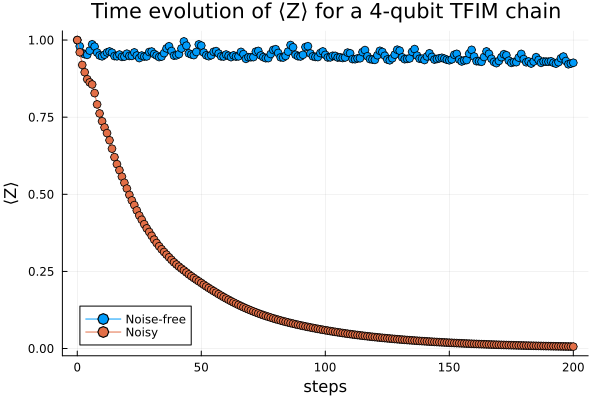

In [43]:
plot(0:trotter.steps,exact_expval_target,
 ylabel="⟨Z⟩", xlabel="steps", label="Noise-free", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy", marker=:o, c=2)
plot!(title = "Time evolution of ⟨Z⟩ for a 4-qubit TFIM chain")

### Training data

In [16]:
list_training_thetas = training_set_generation(trotter; num_samples=10, non_cliffs=30)

10-element Vector{Vector{Float64}}:
 [0.7853981633974483, 0.7853981633974483, 1.0, 0.0, 0.0, 0.2, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483  …  0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0]
 [0.7853981633974483, 1.0, 0.7853981633974483, 0.0, 0.2, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483  …  0.0, 0.0, 0.0, 1.0, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.2, 0.0]
 [0.7853981633974483, 0.7853981633974483, 1.0, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 1.0  …  0.0, 0.0, 0.0, 0.7853981633974483, 1.0, 0.7853981633974483, 0.0, 0.2, 0.0, 0.0]
 [0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.2, 0.2, 0.7853981633974483, 1.0, 0.7853981633974483  …  0.2, 0.0, 0.0, 0.7853981633974483, 1.0, 0.7853981633974483, 0.2, 0.0, 0.0, 0.0]
 [0.7853981633974483, 0.7853981633974483, 1.0, 0.0, 0.0, 0.2, 0.2, 0.7853981633974483, 1.0, 0.7853981633974483  …  0.0, 0.0,

In [22]:
exact_expvals = exact_time_evolution(trotter,list_training_thetas;record = true);
#problem: in the record, we need to take the new corresponding thetas of each layer.

[0.7853981633974483, 0.7853981633974483, 1.0, 0.0, 0.0, 0.2, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 1.0, 1.0, 0.2, 0.0, 0.2, 0.0, 1.0, 0.7853981633974483, 0.7853981633974483, 0.2, 0.0, 0.0, 0.2, 1.0, 1.0, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 1.0, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.2, 0.0, 0.0, 0.2, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.2, 0.2, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.2, 0.2, 1.0, 1.0, 0.7853981633974483, 0.0, 0.0, 0.0, 0.2, 1.0, 0.7853981633974483, 0.7853981633974483, 0.0, 0.2, 0.0, 0.0, 0.7853981633974483, 1.0, 0.78

10-element Vector{Vector{Float64}}:
 [1.0, 0.9950166444603104, 0.9950166444603104, 0.9947902993319847, 0.9777534565438395, 0.9777534565438395, 0.9777534565438395, 0.9945625077181703, 0.9945625077181703, 0.9945625077181703  …  0.9825522136265884, 0.9681742419087295, 0.9496826785391382, 0.9422318772979473, 0.9422318772979473, 0.9321631425541541, 0.941263815823643, 0.9276935964181638, 0.9276935964181638, 0.9276935964181638]
 [1.0, 0.9950166444603104, 0.9900332889206208, 0.9900332889206208, 0.9850499333809313, 0.9850499333809313, 0.9850499333809313, 0.9800665778412416, 0.9682052693262062, 0.9576688086856673  …  0.9338698614954906, 0.9026744385681824, 0.8975985170149035, 0.9204386484100826, 0.9517713415756291, 0.9517713415756291, 0.9517713415756291, 0.9517713415756291, 0.9517713415756291, 0.9482832823008921]
 [1.0, 1.0, 0.9950166444603104, 0.9950166444603104, 0.9950166444603104, 0.9950166444603104, 0.9950166444603104, 0.9850499333809313, 0.9698511917608943, 0.9605937892640143  …  0.95368044

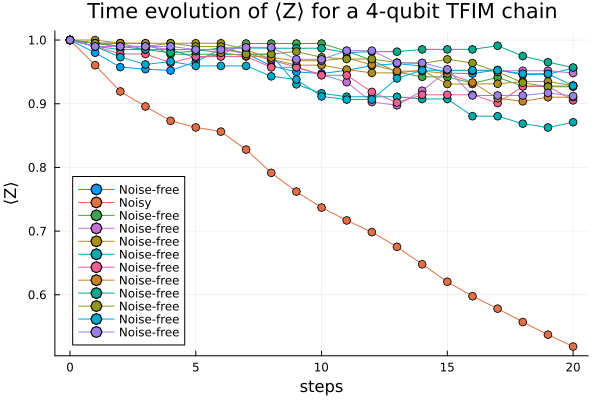

In [ ]:
for i in exact_expvals
    plot!(0:trotter.steps,i, label="Noise-free", marker=:o)
end
plot!(xlabel = "steps", ylabel="⟨Z⟩", title = "Time evolution of ⟨Z⟩ for a 4-qubit TFIM chain")

In [ ]:
noisy_expvals = exact_time_evolution(trotter,list_training_thetas; noisy_circuit = noisy_circuit, record = true);

[0.7853981633974483, 0.7853981633974483, 1.0, 0.0, 0.0, 0.2, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 1.0, 1.0, 0.2, 0.0, 0.2, 0.0, 1.0, 0.7853981633974483, 0.7853981633974483, 0.2, 0.0, 0.0, 0.2, 1.0, 1.0, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 1.0, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.2, 0.0, 0.0, 0.2, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.2, 0.2, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.0, 0.0, 0.2, 0.2, 1.0, 1.0, 0.7853981633974483, 0.0, 0.0, 0.0, 0.2, 1.0, 0.7853981633974483, 0.7853981633974483, 0.0, 0.2, 0.0, 0.0, 0.7853981633974483, 1.0, 0.78

ArgumentError: ArgumentError: The number of thetas must match the number of parametrized gates in the circuit. countparameters(circ)=140, length(thetas)=7.

In [19]:
println(noisy_expvals)

[0.609285864464882, 0.6163790736614586, 0.6008232993121109, 0.5804543009156753, 0.5963524961987783, 0.6052547890735422, 0.6299462249474574, 0.6230058218579826, 0.6228249730132751, 0.6009943189235197]


In [20]:
noisy_circ = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01);

In [21]:
corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals, exact_expvals, noisy_expval_target[end], exact_expval_target[end]; verbose=true)  

10×2 DataFrame
 Row │ x         y        
     │ Float64   Float64  
─────┼────────────────────
   1 │ 0.609286  0.92819
   2 │ 0.616379  0.941353
   3 │ 0.600823  0.914906
   4 │ 0.580454  0.87317
   5 │ 0.596352  0.895951
   6 │ 0.605255  0.917578
   7 │ 0.629946  0.963944
   8 │ 0.623006  0.937874
   9 │ 0.622825  0.931954
  10 │ 0.600994  0.921985
Noisy target expectation value: 0.518633632338328
Relative error before CDR: 0.45738693844465456
CDR-EM target expectation value: 0.7794254091204507
Relative error after CDR: 0.18453725110333474


(0.7794254091204507, 0.18453725110333474, 0.45738693844465456)

## Next steps:
- Problem: AFM does not behave as expected!! we get 1 magnetization , should go to 0!!
- change observable to where correction is not as easy (paramagnetic phase, h = -2, J=1 as in CDR paper), (antiferromagnetic phase: )
- other breaking points: resolution of the timesteps, i.e. smaller gate angels (wont work with Clifford replacement) 
- do the record for the training set evolutions